# Matplotlib Intro

In this reading, we'll learn how to create plots from Pandas data.  Pandas uses a module called matplotlib to create plots.  The matplotlib library is designed to resemble MATPLOT (a programming language for matrices and environment that support visualization).

While we could import matplotlib and make function calls directly to plot data, many Pandas methods for Series and DataFrame objects make this easier.  The documentation gives a nice overview of this integration [here](https://pandas.pydata.org/pandas-docs/stable/visualization.html) with more examples than provided here.

Let's begin by trying to make a pie chart from a Pandas Series.

In [1]:
import pandas as pd
from pandas import Series, DataFrame

In [2]:
# first we'll create a Series with three numbers
s = Series([50, 30, 20])
s

0    50
1    30
2    20
dtype: int64

In [3]:
# there are a bunch of methods of the form Series.plot.METHOD for plotting.
# we we want a pie plot:
s.plot.pie()

**Oops!**  That's not what we wanted.  We created a plot, but it didn't get rendered in the notebook.  It turns out that matplotlib is integrated with Jupyter Notebooks, and sometimes we need a special command to tell Jupyter we want to render plots inline.  Special Jupyter commands begin with a percent sign ("%").  We recommend putting the following at the beginning of all your notebooks (it's a Jupyter command, not Python code, so it won't work in a regular .py file if you were to try that):

In [4]:
%matplotlib inline

Ok, let's try plotting again.

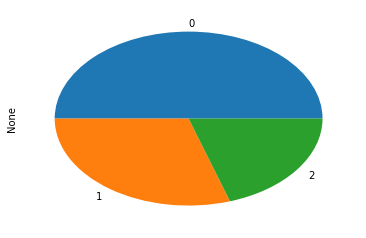

In [5]:
s.plot.pie()

Now we're getting somewhere!  Of course, there are still many issues with this plot:
1. it's oval (not round)
2. each slice is numbered (not labeled)
3. it says "None" to the left

# Pie Plot

Let's address some of the issues we just saw.  First, we can pass a `figsize` tuple argument to specify the (width, height) in inches.  Let's make the pie chart a 6-by-6 inch square.

In [6]:
s = Series([50, 30, 20])
s

0    50
1    30
2    20
dtype: int64

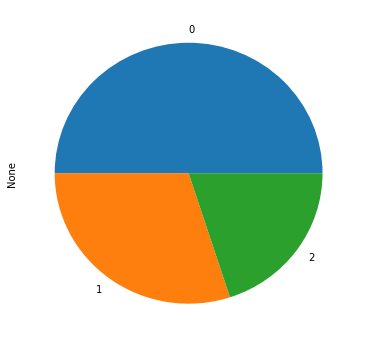

In [7]:
s.plot.pie(figsize=(6,6))

Great!  Now it's the right shape.  What about the slice labels?  These are based on the Series index.  Notice that the numbers 50, 30, and 20 have indices 0, 1, and 2 respectively:

In [8]:
s

0    50
1    30
2    20
dtype: int64

Let's give the Series custom labels and try again.

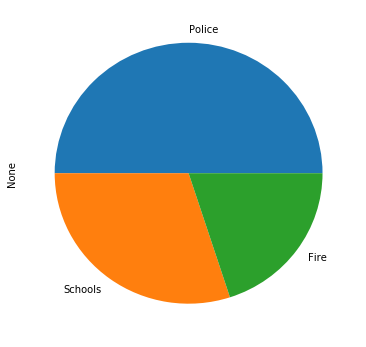

In [9]:
s = Series([50,30,20], index=['Police', 'Schools', 'Fire'])
s.plot.pie(figsize=(6,6))

The final thing to fix is the "None" label to the left.  This label comes from the Series name.  We haven't seen how to specify a Series name before, but it's easy:

In [10]:
s = Series([50,30,20], index=['Police', 'Schools', 'Fire'], name='City Budget')
s

Police     50
Schools    30
Fire       20
Name: City Budget, dtype: int64

Now that the Series was given a name with `name='City Budget'`, we will see it when we plot:

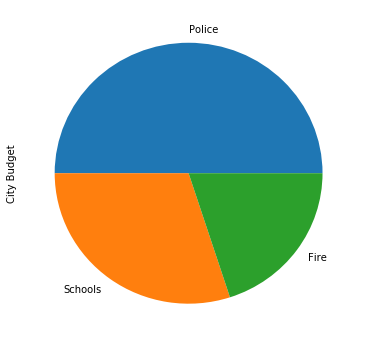

In [11]:
s.plot.pie(figsize=(6,6))

We can also override using the Series name as the label by passing a `label=NAME` argument.

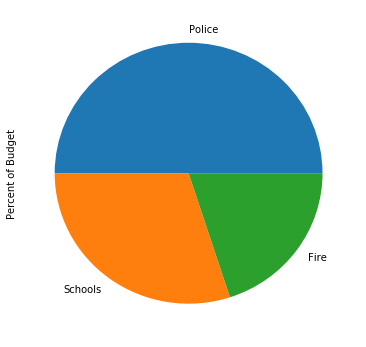

In [12]:
s.plot.pie(figsize=(6,6), label='Percent of Budget')

This means we can also choose not to have a label:

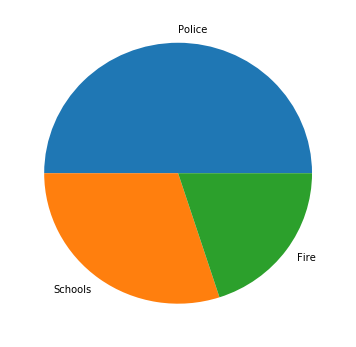

In [13]:
s.plot.pie(figsize=(6,6), label='')

Note that a label is different that a title.  Let's try having a pie chart with both.

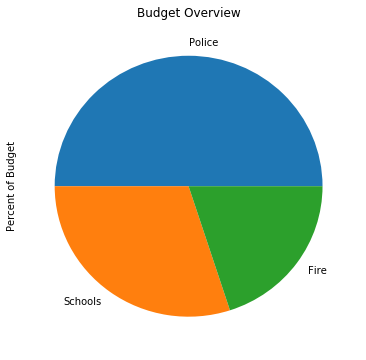

In [14]:
s.plot.pie(figsize=(6,6), label='Percent of Budget', title='Budget Overview')

One thing to be careful about is when the numbers in a Series sum to less than 1.  Matplotlib does not draw a complete pie in this case.

In [15]:
# let's say the numbers are in millions of dollars for a small town
s = Series([0.2,0.12,0.08], index=['Police', 'Schools', 'Fire'], name='City Budget')
s

Police     0.20
Schools    0.12
Fire       0.08
Name: City Budget, dtype: float64

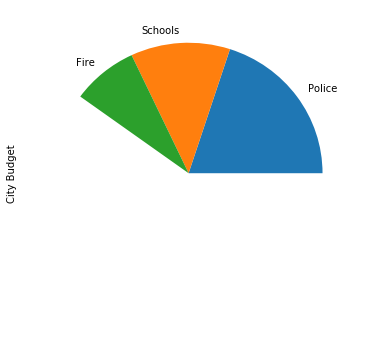

In [16]:
s.plot.pie(figsize=(6,6))

This is easy enough to fix by doing some element-wise multiplication to convert everything to a percent of a total.

In [17]:
percents = 100 * s / sum(s)
percents

Police     50.0
Schools    30.0
Fire       20.0
Name: City Budget, dtype: float64

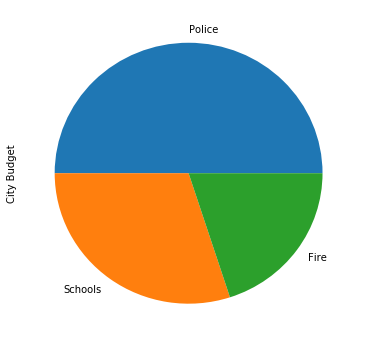

In [18]:
percents.plot.pie(figsize=(6,6))

As a finishing touch, we may want to annotate each slice with a percentage.  We can do this with the `autopct=FORMAT` argument.  `FORMAT` will be a Python format string, telling matplotlib how to display the number.  We haven't learned about format strings this semester, but `%d` will tell matplotlib to format as in integer, and `%f` will tell it to format as a float.  Let's display integers:

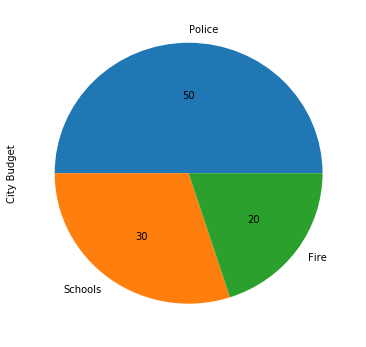

In [19]:
percents.plot.pie(figsize=(6,6), autopct='%d')

# Example: Madison Route Distribution

In this example, we want to show how many people ride the 5 most popular bus routes in Madison, relative to overall ridership.  We'll pull the data from our bus.db database we've used in previous examples.

In [20]:
import sqlite3

In [21]:
c = sqlite3.connect('bus.db')

In [22]:
# let's preview the data
pd.read_sql("SELECT * from boarding LIMIT 10", c)

,index,StopID,Route,Lat,Lon,DailyBoardings
0,0,1163,27,43.073655,-89.385427,1.03
1,1,1163,47,43.073655,-89.385427,0.11
2,2,1163,75,43.073655,-89.385427,0.34
3,3,1164,6,43.106465,-89.340021,10.59
4,4,1167,3,43.077867,-89.369993,3.11
5,5,1167,4,43.077867,-89.369993,2.23
6,6,1167,10,43.077867,-89.369993,0.11
7,7,1167,38,43.077867,-89.369993,1.36
8,8,1169,3,43.089707,-89.329817,18.90
9,9,1169,37,43.089707,-89.329817,1.35


In [23]:
# we want to see the total ridership per bus route
df = pd.read_sql("SELECT Route, SUM(DailyBoardings) as ridership " +
                 "FROM boarding " +
                 "GROUP BY Route " +
                 "ORDER BY ridership DESC", c)

# let's peek at the first few rows in the results from our query
df.head()

,Route,ridership
0,80,10211.79
1,2,4808.03
2,6,4537.02
3,10,4425.23
4,3,2708.55


Now's a good time to stop and think about what form the data is in, and what form we want to get it to.

**What we have:** a DataFrame of routes and ridership, indexed from 0.

**What we want:** a Series of the top 5 buses, with route numbers as the index, and ridership as the values.

Why do we want such a Series?  Because when we call `Series.plot.pie(...)` we want a pie with five slices.  Each pie should be labeled as a bus route (and slice labels are pulled from the index of a Series), and the size of the series should correspond to ridership (and slice sizes are based on the values in a Series).

The first step to getting the data in the form we want is to re-index `df` so that the route numbers are in the index (instead of 0, 1, 2, etc).  We can do this with the `DataFrame.set_index` function.

In [24]:
# set_index doesn't change df, but it returns a new
# DataFrame with the desired column as the new index
ridership_df = df.set_index("Route")
ridership_df.head()

,ridership
Route,
80,10211.79
2,4808.03
6,4537.02
10,4425.23
3,2708.55


In [25]:
# we can pull the (only) ridership column from that DataFrame out
# and keep it as a Series.
ridership = ridership_df['ridership']
ridership.head()

Route
80    10211.79
2      4808.03
6      4537.02
10     4425.23
3      2708.55
Name: ridership, dtype: float64

Great!  Now we have the data in a plottable form.  Let's make the pie chart.

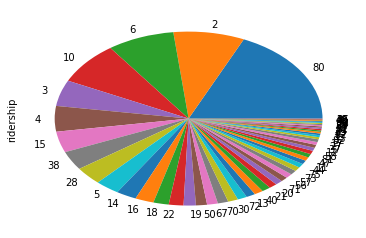

In [26]:
ridership.plot.pie()

This is very close to the form we want!  But we only wanted the top 5 routes.

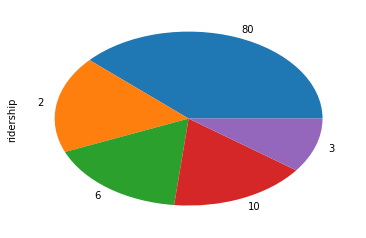

In [27]:
ridership.head(5).plot.pie()

Not bad, but we would ideally have an "other" category that captures all the routes besides the 80, 2, 6, 10, and 3.  How many routes are in this other category?

In [28]:
other_ridership = sum(ridership) - sum(ridership.head(5))
other_ridership

29296.560000000012

Now, we want to glue together the top five values from the `ridership.head(5)` series with a Series of one value (the ridership for other).  We can do this with `pd.concat`.

In [29]:
series1 = ridership.head()
series1

Route
80    10211.79
2      4808.03
6      4537.02
10     4425.23
3      2708.55
Name: ridership, dtype: float64

In [30]:
series2 = Series([other_ridership], index=['other'])
series2

other    29296.56
dtype: float64

In [31]:
plot_data = pd.concat([series1, series2])
plot_data

80       10211.79
2         4808.03
6         4537.02
10        4425.23
3         2708.55
other    29296.56
dtype: float64

That's exactly what we want!  The ridership of the top 5 routes, and the remaining ridership spread across other routes.  Let's plot it.

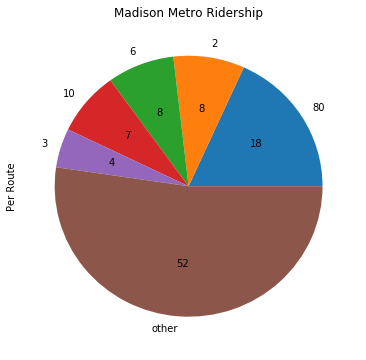

In [32]:
plot_data.plot.pie(figsize=(6,6), autopct="%d", label="Per Route", title="Madison Metro Ridership")

This is exactly what we want.  We can see the top route (the 80) is responsible for 18% of the ridership.  The top 5 routes together are responsible for almost half of all ridership (48%, to be exact).  To wrap up, let's make sure we close our connection to bus.db.

In [33]:
c.close()

# Scatter Plot

A scatter plot displays a collection of points along an x-axis and y-axis.  Whereas pie charts are one-dimensional (we want to see a distribution of one value, such as ridership), scatter plots are naturally two dimensionals (each point has both an x and y position).  Thus, scatter plots are generated from DataFrames (in contrast, pie charts are generated from a Series).

Just as there are a collection of `Series.plot.METHOD` methods, there are also a collection of `DataFrame.plot.METHOD` methods (`scatter` is one of those methods).

Let's begin by plotting some young trees.  Each tree has an age (in years), a height (in feet), and a diameter (in inches).

In [34]:
trees = [
    {"age": 1, "height": 1.5, "diameter": 0.8},
    {"age": 1, "height": 1.9, "diameter": 1.2},
    {"age": 1, "height": 1.8, "diameter": 1.4},
    {"age": 2, "height": 1.8, "diameter": 0.9},
    {"age": 2, "height": 2.5, "diameter": 1.5},
    {"age": 2, "height": 3, "diameter": 1.8},
    {"age": 2, "height": 2.9, "diameter": 1.7},
    {"age": 3, "height": 3.2, "diameter": 2.1},
    {"age": 3, "height": 3, "diameter": 2},
    {"age": 3, "height": 2.4, "diameter": 2.2},
    {"age": 2, "height": 3.1, "diameter": 2.9},
    {"age": 4, "height": 2.5, "diameter": 3.1},
    {"age": 4, "height": 3.9, "diameter": 3.1},
    {"age": 4, "height": 4.9, "diameter": 2.8},
    {"age": 4, "height": 5.2, "diameter": 3.5},
    {"age": 4, "height": 4.8, "diameter": 4},
]
df = DataFrame(trees)
df

,age,diameter,height
0,1,0.8,1.5
1,1,1.2,1.9
2,1,1.4,1.8
3,2,0.9,1.8
4,2,1.5,2.5
5,2,1.8,3.0
6,2,1.7,2.9
7,3,2.1,3.2
8,3,2.0,3.0
9,3,2.2,2.4


Let's plot this data and see if there seems to be any connection between tree age and tree height.  We can create plots like this: `df.plot.scatter(x=FIELD1, y=FIELD2)`.

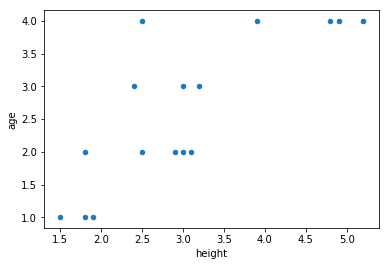

In [35]:
# you can choose which field is represented on the x-axis
# and which is represented on the y-axis.
df.plot.scatter(x='height', y='age')

Although the above plot is informative (we can see that older trees are generally taller), it's not the easiest way to visualize the information.  In general, people are accustomed to seeing time-related data on the x-axis (age is a type of time).  Thus, a more intuitive plot would reverse the axes:

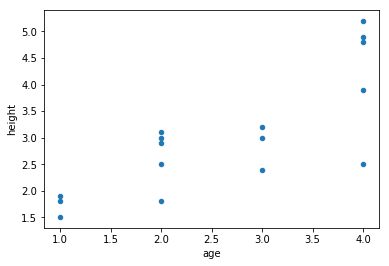

In [36]:
df.plot.scatter(x='age', y='height')

We can also control the color (with the `c` argument) and size (with the `s` argument) of the points:

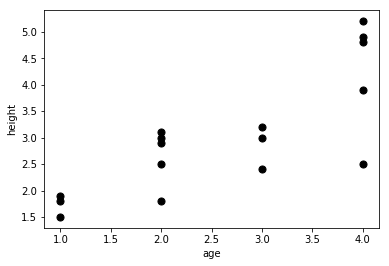

In [37]:
df.plot.scatter(x='age', y='height', c='black', s=50)

# Visually Communicating more Attributes

If we want, we can also use our data to determine the size and color of each point by passing a series for these.  For example, suppose we want tall trees to be represented by large, black circles, and we wanted short trees to be represted with small gray dots.  We can pull out a display Series to control this.

In [38]:
display = df['height'] * 25
display

0      37.5
1      47.5
2      45.0
3      45.0
4      62.5
5      75.0
6      72.5
7      80.0
8      75.0
9      60.0
10     77.5
11     62.5
12     97.5
13    122.5
14    130.0
15    120.0
Name: height, dtype: float64

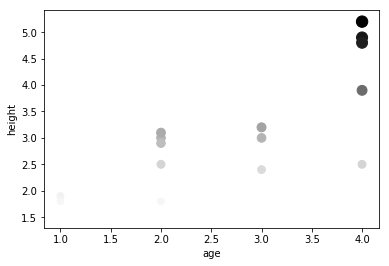

In [39]:
df.plot.scatter(x='age', y='height', c=display, s=display)

Bigger numbers in the `display` Series (or any Series used with `c=`) results in darker dots, and bigger numbers also determine the size of the dots.

The above plot is an example of a **reduntant** visualization.  It's reduntant because three characteristics of the plot (x-axis, dot color, and dot size) are all being used to communicate the same characteristic of the data (height).  This is a wasteful use of plot characteristics, considering that we didn't communicate anything about tree diameter.

When you're thinking about how to visualize your data, you should list the interesting attributes of your data as well as the dimensions you can communicate with the plot.  Then carefully consider how to use each dimension of your plot to communicate something interesting.

In this case, we have **three attributes** in our data:
1. tree age
2. tree height
3. tree diameter

We also have **four dimensions** we can control in our plot:
1. x-axis
2. y-axis
3. dot size
4. dot color

Which dimensions should communicate which attributes?  Exact opinions will vary, but some combinations are more effective than others.

One good combination will be x-axis for age, y-axis for height, and dot size for diameter.  As mentioned before, the x-axis is often used to communicate an elapsed time (an age).  It also feels very natural for a vertical axis to communicate height.  Finally, dot size seems like a better fit for diameter than color for two reasons.  First, it is intuitive to pair a spatial attribute with a spatial characteristic of the plot.  Second, color is often a tricky dimension to use.  Gray can be too light to see, printed copies will very in how good they look, and finally you need to think about how accessible your plots will be for color-blind readers.

Let's see how the data looks with our final choices:

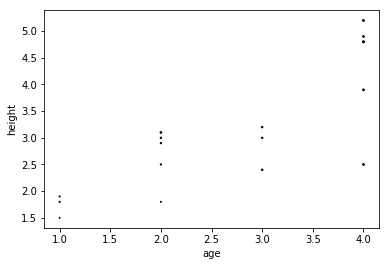

In [40]:
df.plot.scatter(x='age', y='height', s=df['diameter'], c='black')

Those dots are a little small, and the visualization is relative (there's no scale specifying what a given dot size means), so we're free to multiply the diameter by a number of our choosing to make it more aesthetically pleasing.

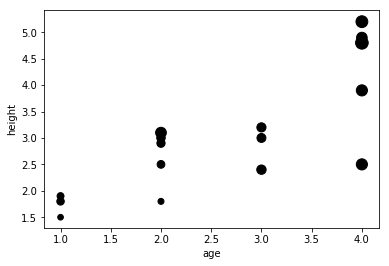

In [41]:
df.plot.scatter(x='age', y='height', s=df['diameter'] * 40, c='black')

# Example: Iris Data

An [Iris](https://en.wikipedia.org/wiki/Iris_%28plant%29) is a type of flowering plant.  There is a very popular dataset (often used in machine learning examples) containing a description of the dimensions of 150 Iris plants from 3 different types of Iris.

The dataset is at [https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data), and a description of the data is [here](https://archive.ics.uci.edu/ml/datasets/iris).  We will plot the data for each of the three types of Iris to visually identify patterns in the data.

As a first step, let's try fetching and loading the CSV data.

In [42]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
df.head()

,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


Oops!  There's no CSV header in that file, so we have to tell Pandas what each field means.  From the documentation, we see the following:

>1. sepal length in cm 
>2. sepal width in cm 
>3. petal length in cm 
>4. petal width in cm 
>5. class:  
>-- Iris Setosa  
>-- Iris Versicolour  
>-- Iris Virginica

Let's try again using `header=`.

In [43]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                 names=['sepal-len', 'sepal-wid', 'petal-len', 'petal-wid', 'name'])
df.head()

,sepal-len,sepal-wid,petal-len,petal-wid,name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Great!  Now lets see how many flowers there are of each type.

In [44]:
iris_types = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

for name in iris_types:
    rows = df[df['name'] == name]
    print(name, len(rows))

Iris-setosa 50
Iris-versicolor 50
Iris-virginica 50


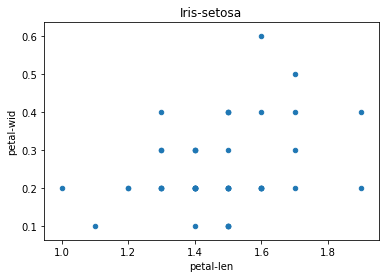

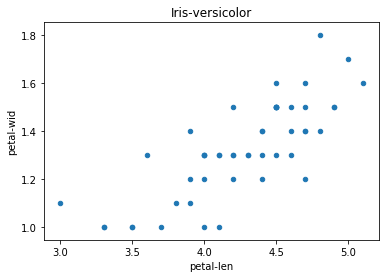

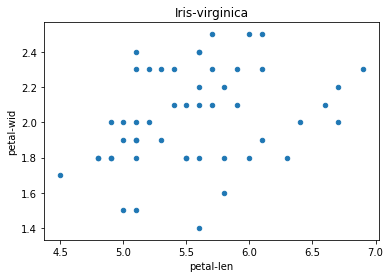

In [45]:
for name in iris_types:
    rows = df[df['name'] == name]
    rows.plot.scatter(x='petal-len', y='petal-wid', title=name)

*What if we want just one plot showing all three flower types?*  In order to distinguish, we would want the dots for each flower type to be a different color.

It turns out that whenever we call a `DataFrame.plot.METHOD` method, it returns an `AxesSubplot` object.  An AxesSubplot object represents the area where we're displaying our data.  If we pass it to other `DataFrame.plot.METHOD` methods, we can indicate that we want the newly plotted data to appear in the same region where we previously plotted.  The argument for this is called `ax`, short for `AxesSubplot`.  Let's try it.

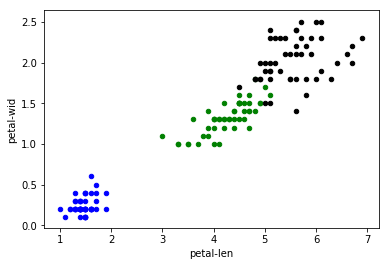

In [46]:
ax = df[df['name'] == 'Iris-setosa'].plot.scatter(x='petal-len', y='petal-wid', c='blue')
df[df['name'] == 'Iris-versicolor'].plot.scatter(x='petal-len', y='petal-wid', c='green', ax=ax)
df[df['name'] == 'Iris-virginica'].plot.scatter(x='petal-len', y='petal-wid', c='black', ax=ax)

From this plot, we can make several observations:
1. petal length is generally correlated with petal width
2. the Setosa variety is smallest along both dimensions
3. the Virginica variety is largest along both dimensions

What about sepal size?  We leave that as an exercise for you!

# Conclusion

In this reading, we have learned how to create a pie chart from a Pandas Series and a scatter plot from a Pandas DataFrame.  We have also discussed the decision making process for choosing which plot characteristics should represent which data attributes.  Finally, we learned how about AxesSuplot objects and how to use them to plot multiple datasets in the same region.  We did all of this in the context of two example datasets: the Madison Metro dataset and the popular Iris dataset.